# [📖 Main Menu](index.html)

In [1]:
using StatsBase, DataFrames, DataFrameMacros
using RCall, CategoricalArrays, TexTables
using Distributions, Gadfly, Compose, MLJ
using AnovaGLM, Effects, StandardizedPredictors
using MLJ: schema
include("pubh.jl");

In [2]:
include("pubh.jl")
set_default_plot_size(15cm, 12cm)
@rlibrary readr
@rimport pubh

# Univariate Analysis

## Introduction

In [3]:
kfm = read_rds("data/kfm.rds") |> rcopy
kfm |> schema

┌────────────┬───────────────┬──────────────────────────────────┐
│ names      │ scitypes      │ types                            │
├────────────┼───────────────┼──────────────────────────────────┤
│ no         │ Count         │ Int64                            │
│ dl_milk    │ Continuous    │ Float64                          │
│ sex        │ Multiclass{2} │ CategoricalValue{String, UInt32} │
│ weight     │ Continuous    │ Float64                          │
│ ml_suppl   │ Count         │ Int64                            │
│ mat_weight │ Count         │ Int64                            │
│ mat_height │ Count         │ Int64                            │
└────────────┴───────────────┴──────────────────────────────────┘


In [4]:
#| code-fold: true
summarize_by(@select(kfm, {Not(:no)}), :sex)

     |            | Obs |  Mean   | Std. Dev. |  Min  |  Max   
---------------------------------------------------------------
 Boy |    dl_milk |  25 |   7.952 |     1.492 | 4.910 | 10.430 
     |     weight |  25 |   5.438 |     0.570 | 4.360 |  6.578 
     |   ml_suppl |  25 | 105.200 |   143.530 |     0 |    555 
     | mat_weight |  25 |  60.400 |     8.062 |    48 |     78 
     | mat_height |  25 | 168.200 |     7.483 |   153 |    185 
---------------------------------------------------------------
Girl |    dl_milk |  25 |   7.056 |     1.422 | 4.440 | 10.030 
     |     weight |  25 |   5.199 |     0.509 | 4.120 |  6.100 
     |   ml_suppl |  25 |  86.800 |   117.658 |     0 |    590 
     | mat_weight |  25 |  59.520 |     8.832 |    47 |     80 
     | mat_height |  25 | 166.680 |     5.437 |   157 |    176 


We would like to check if the distributions of our outcome and our primary predictor are normal or close to normal.

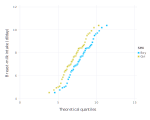

In [5]:
#| label: fig-fig1
#| fig-cap: "QQ-Plots of outcome of interest, daily breast milk intake by sex."
let
	kfm_comb = DataFrames.combine(groupby(kfm, :sex), :dl_milk=>(x->fit(Normal, x))=>:d)
	
	plot(
		kfm_comb,
		x=:d, y=kfm.dl_milk, color=:sex,
		Stat.qq,
		Guide.xlabel("Theoretical quantiles"),
		Guide.ylabel("Breast-milk intake (dl/day)")
	)
end

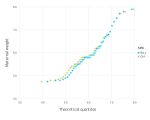

In [6]:
#| label: fig-fig2
#| fig-cap: "QQ-Plots of main predictor of interest, maternal weight by sex."
let
	kfm_comb = DataFrames.combine(groupby(kfm, :sex), :mat_weight=>(x->fit(Normal, x))=>:d)
	
	plot(
		kfm_comb,
		x=:d, y=kfm.mat_weight, color=:sex,
		Stat.qq,
		Guide.xlabel("Theoretical quantiles"),
		Guide.ylabel("Maternal weight")
	)
end

We can plot the linear relationship between maternal weight and breast-milk intake for all the cases (unadjusted).

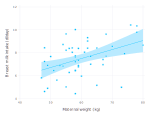

In [7]:
#| label: fig-fig3
#| fig-cap: "Relationship between breast-milk intake in infants and maternal weight. The black line shows a linear model fit with a 95% CIs band."
plot(
	kfm,
	x = :mat_weight, y = :dl_milk,
	Geom.point, 
	layer(Stat.smooth(method=:lm), Geom.line, Geom.ribbon),
	Guide.xlabel("Maternal weight (kg)"),
	Guide.ylabel("Breast milk intake (dl/day) ")
)

### Simple Linear Regression

A univariate analysis is what people from epidemiology call *unadjusted*. We will perform the univariate analysis to understand concepts like confounding and interactions better.

In [8]:
model_1 = lm(@formula(dl_milk ~ mat_weight), kfm)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

dl_milk ~ 1 + mat_weight

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error     t  Pr(>|t|)   Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  2.80837     1.41935    1.98    0.0536  -0.045414    5.66216
mat_weight   0.0783193   0.0234481  3.34    0.0016   0.0311737   0.125465
─────────────────────────────────────────────────────────────────────────

Corresponding coefficient of determination:

In [9]:
model_1 |> r2 |> r3

0.189

## Centring

The value of the intercept of $\beta_0$ = 2.81 is the predicted consumption of breast-milk intake in a day by an infant born from a mother with a weight of 0 kg. To make a better interpretation of this coefficient, we could centre the values of maternal weight. Centring involves removing the mean value to each one of the observations. By definition, the mean of the centre variable is zero, so the intercept would represent the value for the average maternal weight.

In [10]:
model_2 = lm(
	@formula(dl_milk ~ mat_weight),
	kfm;
	contrasts = Dict(:mat_weight => Center())
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

dl_milk ~ 1 + mat_weight(centered: 59.96)

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────
                                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                  7.5044      0.194547   38.57    <1e-37  7.11324     7.89556
mat_weight(centered: 59.96)  0.0783193   0.0234481   3.34    0.0016  0.0311737   0.125465
─────────────────────────────────────────────────────────────────────────────────────────

Let's check descriptive statistics!

In [11]:
estat(
	@select(kfm, :dl_milk, :mat_weight),
	["Breast-milk intake (dl/day)", "Maternal weight (kg)"]
)

2×6 DataFrame
 Row │ Variable                     n      Median   Mean     SD       CV      
     │ String                       Int64  Float64  Float64  Float64  Float64 
─────┼────────────────────────────────────────────────────────────────────────
   1 │ Breast-milk intake (dl/day)     50     7.66    7.504    1.512    0.201
   2 │ Maternal weight (kg)            50    58.0    59.96     8.381    0.14

**YAY!!**

# Multivariate Analysis

For the multivariate analysis, we will start by controlling by all potential confounders.

In [12]:
kfm_cont = Dict(
	:mat_weight => Center(),
	:mat_height => Center(),
	:sex => EffectsCoding()
);

In [13]:
model_3 = lm(
	@formula(dl_milk ~ mat_weight + sex  + ml_suppl + mat_height),
	kfm; contrasts = kfm_cont
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

dl_milk ~ 1 + mat_weight(centered: 59.96) + sex + ml_suppl + mat_height(centered: 167.44)

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────
                                    Coef.  Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                    7.65913     0.225182    34.01    <1e-33   7.20559      8.11267
mat_weight(centered: 59.96)    0.0336862   0.026633     1.26    0.2124  -0.0199554    0.0873278
sex: Girl                     -0.378385    0.179204    -2.11    0.0403  -0.73932     -0.017449
ml_suppl                      -0.00161181  0.00144043  -1.12    0.2691  -0.00451299   0.00128937
mat_height(centered: 167.44) 

In [14]:
anova(model_3)

Analysis of Variance

Type 1 test / F test

dl_milk ~ 1 + mat_weight(centered: 59.96) + sex + ml_suppl + mat_height(centered: 167.44)

Table:
──────────────────────────────────────────────────────────────────────────────
                              DOF     Exp.SS  Mean Square    F value  Pr(>|F|)
──────────────────────────────────────────────────────────────────────────────
(Intercept)                     1  2815.80      2815.80    1782.9896    <1e-37
mat_weight(centered: 59.96)     1    21.11        21.11      13.3686    0.0007
sex                             1     8.5749       8.5749     5.4297    0.0243
ml_suppl                        1     0.2856       0.2856     0.1808    0.6727
mat_height(centered: 167.44)    1    10.91        10.91       6.9077    0.0117
(Residuals)                    45    71.07         1.5793               
──────────────────────────────────────────────────────────────────────────────



In [15]:
anova(model_3; type=3)

Analysis of Variance

Type 3 test / F test

dl_milk ~ 1 + mat_weight(centered: 59.96) + sex + ml_suppl + mat_height(centered: 167.44)

Table:
──────────────────────────────────────────────────────────────────────────────
                              DOF     Exp.SS  Mean Square    F value  Pr(>|F|)
──────────────────────────────────────────────────────────────────────────────
(Intercept)                     1  1827.03      1827.03    1156.8898    <1e-33
mat_weight(centered: 59.96)     1     2.5265       2.5265     1.5998    0.2124
sex                             1     7.0408       7.0408     4.4583    0.0403
ml_suppl                        1     1.9774       1.9774     1.2521    0.2691
mat_height(centered: 167.44)    1    10.91        10.91       6.9077    0.0117
(Residuals)                    45    71.07         1.5793               
──────────────────────────────────────────────────────────────────────────────



## Model Simplification

ANOVA reports $p$-values from $F$-tests. A summary of a regression model reports $p$-values from $t$-tests. $F$-tests compares a model that includes a particular parameter, against the model that does not have such parameter. In other words, it tests if removing a particular variable from a model is significant or not. 
$t$-tests, tests the slope of a parameter, i.e., against the null value of zero (no effect), adjusted by the other parameters in the model.

For model simplification, we are interested in removing parameters which do not have a significant contribution to the model, i.e., that if we remove them, the model would not be significantly different from the model that contains the parameter.

We will remove, one parameter at a time, starting with the one with the highest non-significant $p$-value (as long as the parameter is not our predictor of interest). For model simplification, we start looking first at interaction terms, but as currently, we do not have any, we remove `ml_suppl`.

In [16]:
model_4 = lm(
	@formula(dl_milk ~ mat_weight + sex + mat_height),
	kfm; contrasts = kfm_cont
)

anova(model_4; type=3)

Analysis of Variance

Type 3 test / F test

dl_milk ~ 1 + mat_weight(centered: 59.96) + sex + mat_height(centered: 167.44)

Table:
──────────────────────────────────────────────────────────────────────────────
                              DOF     Exp.SS  Mean Square    F value  Pr(>|F|)
──────────────────────────────────────────────────────────────────────────────
(Intercept)                     1  2815.80      2815.80    1773.2709    <1e-37
mat_weight(centered: 59.96)     1     3.8154       3.8154     2.4028    0.1280
sex                             1     6.6982       6.6982     4.2183    0.0457
mat_height(centered: 167.44)    1     9.2173       9.2173     5.8047    0.0200
(Residuals)                    46    73.04         1.5879               
──────────────────────────────────────────────────────────────────────────────



We can use information criteria (IC) for model simplification. Both Akaike’s information criterion (AIC) and Bayesian information criterion (BIC) penalise the number of parameters in the model. The more parameters included in the model, the more penalty is given. It can be calculated with the following formula:

$$IC = -2 × \mathbf{log-likelihood} + k(p)$$

where $p$ is the number of parameters in the model (including the intercept). For AIC, $k$ = 2, whereas for BIC, $k = log(n)$, where $n$ is the number of observations. 

In [17]:
aic(model_3) |> r3, aic(model_4) |> r3

(171.474, 170.846)

In [18]:
bic(model_3) |> r3, bic(model_4) |> r3

(182.946, 180.406)

Another way to look at coefficients is through a plot of coefficients. In these kind of plots, the intercept is omitted by default.

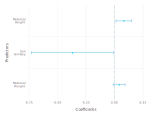

In [19]:
#| label: fig-fig4
#| fig-cap: "Coefficient plot showing the effect of different predictors on daily breast-milk intake."
coef_plot(model_4, ["Maternal\n Weight", "Sex\n Girl-Boy", "Maternal\n Height"])

## Interactions

Let's make a quick plot to see if sex appears to affect the relationship between maternal weight and daily breast-milk intake.

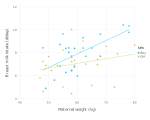

In [20]:
#| label: fig-fig5
#| fig-cap: "Relationship between breast-milk intake in infants and maternal weight, by sex. Lines represent linear regression models."
#| warning: false
plot(
	kfm,
	x = :mat_weight, y = :dl_milk, color = :sex,
	Geom.point, Geom.smooth(method = :lm),
	Guide.xlabel("Maternal weight (kg)"),
	Guide.ylabel("Breast milk intake (dl/day) ")
)

Let's add an interaction to our last model.

In [21]:
model_5 = lm(
	@formula(dl_milk ~ mat_weight * sex + mat_height),
	kfm; contrasts = kfm_cont
)

anova(model_5; type=3)

Analysis of Variance

Type 3 test / F test

dl_milk ~ 1 + mat_weight(centered: 59.96) + sex + mat_height(centered: 167.44) + mat_weight(centered: 59.96) & sex

Table:
───────────────────────────────────────────────────────────────────────────────────
                                   DOF     Exp.SS  Mean Square    F value  Pr(>|F|)
───────────────────────────────────────────────────────────────────────────────────
(Intercept)                          1  2798.51      2798.51    1779.1254    <1e-37
mat_weight(centered: 59.96)          1     4.9998       4.9998     3.1786    0.0814
sex                                  1     6.8740       6.8740     4.3701    0.0423
mat_height(centered: 167.44)         1     6.5367       6.5367     4.1556    0.0474
mat_weight(centered: 59.96) & sex    1     2.2604       2.2604     1.4370    0.2369
(Residuals)                         45    70.78         1.5730               
───────────────────────────────────────────────────────────────────────────────────

In [22]:
bic(model_4) |> r3, bic(model_5) |> r3

(180.406, 182.746)

## Stratification

Statistics do not tell the whole story, it helps us to understand our variables, to make inferences, to assess if a given difference is the result of chance. We still need to use common sense and the theory of our field (in my case, health sciences and biology) to interpret results.

The interaction term is not statistically significant and is likely that a statistician would recommend to remove it from our model. It would make sense from a statistical point of view.

The relationship between maternal weight and daily breast-milk intake is not the same between boys and girls. It is common and expected to find differences in clinical parameters between sexes.

From our scatter plot, we know that though the effect of maternal weight on breast-milk intake is positive for both sexes, the magnitude of such effect is not the same.

We will fit a regression model for boys and another regression model for girls, i.e., the stratified approach.

First we create our subsets:

In [23]:
boys = @subset(kfm, :sex == "Boy")
girls = @subset(kfm, :sex == "Girl");

Contrasts for the models (centring):

In [24]:
sex_cont = Dict(
	:mat_weight => Center(),
	:mat_height => Center()
);

In [25]:
model_boy = lm(
	@formula(dl_milk ~ mat_weight + mat_height),
	boys; contrasts=sex_cont
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

dl_milk ~ 1 + mat_weight(centered: 60.4) + mat_height(centered: 168.2)

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────
                                 Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                  7.9524      0.239467   33.21    <1e-19   7.45578     8.44902
mat_weight(centered: 60.4)   0.102837    0.0403624   2.55    0.0183   0.0191306   0.186544
mat_height(centered: 168.2)  0.0234938   0.043485    0.54    0.5944  -0.0666886   0.113676
──────────────────────────────────────────────────────────────────────────────────────────

In [26]:
model_girl = lm(
	@formula(dl_milk ~ mat_weight + mat_height),
	girls; contrasts=sex_cont
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

dl_milk ~ 1 + mat_weight(centered: 59.52) + mat_height(centered: 166.68)

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────
                                   Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                   7.0564       0.253213   27.87    <1e-17   6.53127    7.58153
mat_weight(centered: 59.52)   0.00216142   0.0331063   0.07    0.9485  -0.0664968  0.0708196
mat_height(centered: 166.68)  0.134988     0.0537816   2.51    0.0199   0.0234518  0.246524
────────────────────────────────────────────────────────────────────────────────────────────

## Table of coefficients

We can generate a table of coefficients with the name of the model, or a more clean version with coeftable.

In [27]:
model_4 |> coeftable |> DataFrame

4×7 DataFrame
 Row │ Name                          Coef.       Std. Error  t         Pr(>|t| ⋯
     │ String                        Float64     Float64     Float64   Float64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ (Intercept)                    7.5044      0.178209   42.1102   2.18433 ⋯
   2 │ mat_weight(centered: 59.96)    0.0403486   0.02603     1.55008  0.12797
   3 │ sex: Girl                     -0.368626    0.179482   -2.05384  0.04570
   4 │ mat_height(centered: 167.44)   0.0810793   0.0336528   2.40929  0.02004
                                                               3 columns omitted

In [28]:
glm_coef(model_4 |> coeftable |> DataFrame, ratio=false)

4×5 DataFrame
 Row │ Name                          Coef.    Lower 95%  Upper 95%  Pr(>|t|) 
     │ String                        Float64  Float64    Float64    Float64  
─────┼───────────────────────────────────────────────────────────────────────
   1 │ (Intercept)                     7.504      7.146      7.863     0.0
   2 │ mat_weight(centered: 59.96)     0.04      -0.012      0.093     0.128
   3 │ sex: Girl                      -0.369     -0.73      -0.007     0.046
   4 │ mat_height(centered: 167.44)    0.081      0.013      0.149     0.02

## Diagnostics

The performance data frames:

In [29]:
boy_perf = model_perf(model_boy)
girl_perf = model_perf(model_girl);

### Normality

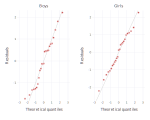

In [30]:
#| label: fig-fig6
#| fig-cap: "QQ-Plots of residuals from models stratified by sex."
let
	p1 = resid_plot(boy_perf, title = "Boys")
	p2 = resid_plot(girl_perf, title = "Girls")

	hstack(p1, p2)
end

### Homoscedasticity

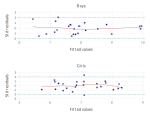

In [31]:
#| label: fig-fig7
#| fig-cap: "Fitted vs residuals plot for the stratified models."
let
	p1 = rvf_plot(boy_perf, title = "Boys")
	p2 = rvf_plot(girl_perf, title = "Girls")

	vstack(p1, p2)
end

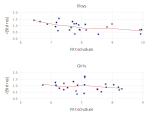

In [32]:
let
	p1 = variance_plot(boy_perf, title = "Boys")
	p2 = variance_plot(girl_perf, title = "Girls")

	vstack(p1, p2)
end

### Influential observations

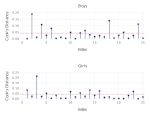

In [33]:
#| label: fig-fig8
#| fig-cap: "Cook's distance to detect potential outliers from the stratified models."
let
	p1 = cooks_plot(boy_perf, title = "Boys")
	p2 = cooks_plot(girl_perf, title = "Girls")

	vstack(p1, p2)
end

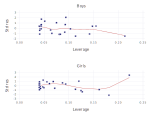

In [34]:
#| label: fig-fig9
#| fig-cap: "Residuals vs leverage plots."
let
	p1 = res_lev_plot(boy_perf, title = "Boys")
	p2 = res_lev_plot(girl_perf, title = "Girls")

	vstack(p1, p2)
end

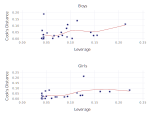

In [35]:
#| label: fig-fig10
#| fig-cap: "Cook's distance vs leverage plots."
let
	p1 = cook_lev_plot(boy_perf, title = "Boys")
	p2 = cook_lev_plot(girl_perf, title = "Girls")

	vstack(p1, p2)
end

### Performance statistics

In [36]:
@show r2(model_boy) |> r3; @show r2(model_girl) |> r3;

r2(model_boy) |> r3 = 0.409
r2(model_girl) |> r3 = 0.273


In [37]:
@show adjr2(model_boy) |> r3; @show adjr2(model_girl) |> r3;

adjr2(model_boy) |> r3 = 0.356
adjr2(model_girl) |> r3 = 0.207


In [38]:
@show mape(boy_perf) |> r3; @show mape(girl_perf) |> r3;

mape(boy_perf) |> r3 = 0.005
mape(girl_perf) |> r3 = 0.005


In [39]:
@show rmse(boy_perf) |> r3; @show rmse(girl_perf) |> r3;

rmse(boy_perf) |> r3 = 1.123
rmse(girl_perf) |> r3 = 1.188
